In [1]:
import GLDF

# Tutorial 02: More Detailed Configurations

This tutorial presents again two simple examples (similar to those in the first tutorial):
1. Application to time series data with temporally persistent regimes, this time configured for latents
2. Application to gridded data with spatially localized regimes, this time using PC-stable in place of FCI

## 1. Time-Series and Latents

Time-series with latents by using tigramite's LPCMCI implementation works out of the box, using 'run_hccd_temporal_regimes' with 'allow_latent_confounding=True' option.
This part of the tutorial explains, how the built-in configurations can be customized, on the example of reimplementing this feature.

The standard-configurations are data-classes, and we can inspect parameters as follows
(these simple parameters can be modified simply by obtaining a configuration object, e.g. via configure_hccd_temporal_regimes, overwriting the value, and then calling run(data)
on the configuration object):

In [2]:

from dataclasses import asdict
print(asdict(GLDF.frontend.configure_hccd_temporal_regimes()))

{'is_timeseries': True, 'alpha': 0.01, 'min_regime_fraction': 0.15, 'indicator_resolution_granularity': 100, 'regimes_are_large': True, 'tau_max': 1, 'alpha_pc1': 0.1, '_data': None}


The backend has a rather large number of modules all of which can operate mostly independently.
If changing only some of them, we could simiply copy-and-paste the code which instantiates and composes all of them, and switch out those we want to change.
However, this would not be well-maintainable: If a future version improves or restructures any part of the frontend, or if we want to allow the combination
of different modifications at different modules of the frontend, this idea very quickly reaches its limitations.

So instead, also the frontend is made modular. It is exposed in form of "configuration-class" which implement getters for (many) different (sub-)modules in
in the backend. These (sub-)modules are constructed and composed with other (sub-)modules obtained in turn through other getters.
This means, any (sub-)modul can simply be swapped out by replacing its getter! All other (sub-)modules connecting to this component will
automatically get "rewired" as they call only the (new) getter to access this component.

Put simply, if we want for example to replace PCMCI+ by LPCMCI, we can simply start from the "default" timer-series configuration,
and replace the "universal CD" getter.
Indeed in this case (see the documentation of bridges.tigramite.alg_lpcmci), we also have to switch out the
HCCD-controller. But this can be achieved just as easily.

In [5]:
class ConfigureHCCD_LPCMCI(GLDF.frontend.ConfigureHCCD):
    def __init__(self, regimes_are_large: bool=True, alpha: float=0.01, alpha_pc1: float=0.1):
        ts_config = GLDF.frontend.configure_hccd_temporal_regimes(regimes_are_large=regimes_are_large, alpha=alpha, alpha_pc1=alpha_pc1)
        from dataclasses import asdict
        super().__init__(**asdict(ts_config))
    

    def get_universal_cd(self) -> GLDF.hccd.abstract_cd_t:
        return GLDF.bridges.tigramite.alg_lpcmci(data_format=self.get_data_manager())

    def get_controller(self) ->GLDF.hccd.Controller:
        return GLDF.hccd.ControllerTimeseriesLPCMCI(universal_cd=self.get_universal_cd(), testing_backend=self.get_transitionable_backend(), state_space_construction=self.get_state_space_construction())

That's it already. After generating data, we can simply create an instance of this configuration and run it on the data.

In [8]:
import numpy as np

N = 1000

R = np.zeros(N, dtype=bool)
R[int(N/2):] = True

rng = np.random.default_rng()
X_noise = rng.standard_normal(N)
Y_noise = rng.standard_normal(N)
Z_noise = rng.standard_normal(N)
L_noise = rng.standard_normal(N)
W_noise = rng.standard_normal(N)

X = np.empty_like(X_noise)
Y = np.empty_like(Y_noise)
Z = np.empty_like(Z_noise)
L = np.empty_like(L_noise)
W = np.empty_like(W_noise)

def lag_one_or_zero(values, t):
    return values[t-1] if t > 0 else 0.0

for t in range(N):
    # latent
    L[t] = L_noise[t] # + 0.25 * lag_one_or_zero(L, t)
    # observables:
    W[t] = W_noise[t] + 0.15 * lag_one_or_zero(W, t)
    X[t] = X_noise[t] + 0.2 * lag_one_or_zero(X, t) - 0.7 * lag_one_or_zero(W, t) + 1.2 * L[t]
    Z[t] = Z_noise[t]
    Y[t] = Y_noise[t] + R[t] * lag_one_or_zero(X, t) + Z[t] + 0.8 * lag_one_or_zero(L, t)

data = np.array([X,Y,Z,W]).T
var_names = ["X", "Y", "Z", "W"]

Regime-detection with latents in time-series is still experimental, in particular it may have low recall on regimes.
For example commenting in the auto-lag on L in the example above leads to problems. The deeper problem is not necessarily
related to auto-lagged confounders, but they provide one example why time-series causal-discovery with latents
in general is a very complex and difficult problem.

In [9]:
import numpy as np

N = 1000

R = np.zeros(N, dtype=bool)
R[int(N/2):] = True

rng = np.random.default_rng()
L = rng.standard_normal(N)
W = rng.standard_normal(N)
X = rng.standard_normal(N) + L + W
Z = rng.standard_normal(N)
Y = rng.standard_normal(N) + L + R * Z

data = np.array([X,Y,Z,W]).T
var_names = ["X", "Y", "Z", "W"]

In [10]:
config = ConfigureHCCD_LPCMCI()
result = config.run(data)

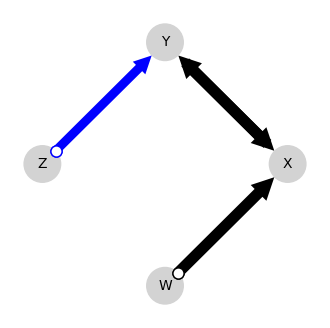

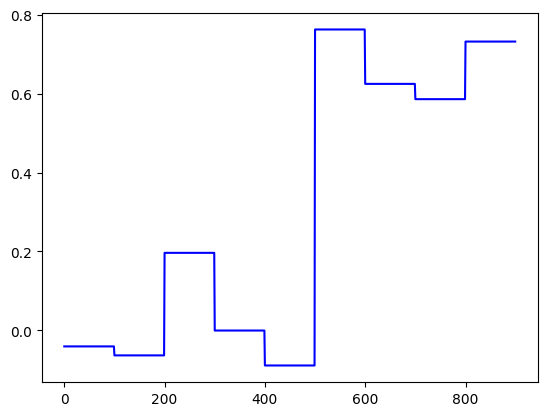

In [11]:
import matplotlib.pyplot as plt
result.var_names = var_names
result.plot_labeled_union_graph()
plt.show()
for mi in result.model_indicators():
    mi.plot_resolution()
    plt.show()

## 2. Spatial Regimes with PC-stable

In the first tutorial, we ran an example with spatial regimes and FCI (allowing for latent confounding).
Here we re-configure the setup to run with PC-stable (no latent confounding).

As in the first part, we copy a default configuration (in this case configure_hccd_spatial_regimes) and replace the
universal-cd module.

In [12]:
class ConfigureHCCD_PCstable(GLDF.frontend.ConfigureHCCD):
    def __init__(self, regimes_are_large: bool=True, alpha: float=0.01):
        std_config = GLDF.frontend.configure_hccd_spatial_regimes(regimes_are_large=regimes_are_large, alpha=alpha)
        from dataclasses import asdict
        super().__init__(**asdict(std_config))    

    def get_universal_cd(self) -> GLDF.hccd.abstract_cd_t:
        return GLDF.bridges.causal_learn.alg_pc_stable(data_format=self.get_data_manager())

We use the same data-generation as in the first tutorial:

In [13]:
import numpy as np

def get_data(seed=None):
    data_size = (100, 100)
    A = np.full(data_size, False)
    A[:50,:] = True
    B = np.full(data_size, False)
    B[:,:50] = True

    rng = np.random.default_rng(seed=seed)

    X = rng.standard_normal(data_size)
    Y = rng.standard_normal(data_size)
    L = rng.standard_normal(data_size) # latent
    Z = rng.standard_normal(data_size) + A * X + L
    W = rng.standard_normal(data_size) + Y + B * L

    return np.array([X,Y,Z,W]).transpose([1,2,0])

var_names = ["X", "Y", "Z", "W"]
data = get_data(seed=17062025)
print(data.shape)

(100, 100, 4)


**Note:** This example *does* contain latent confounding. Here this leads to orientation-conflicts (x-markings in graph). In general there is of course no guarantee that inconsistencies with assumptions will be found.

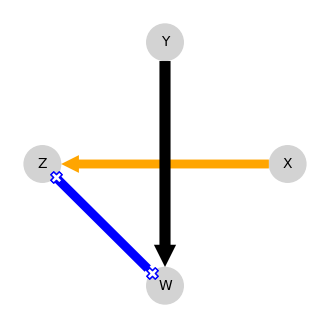

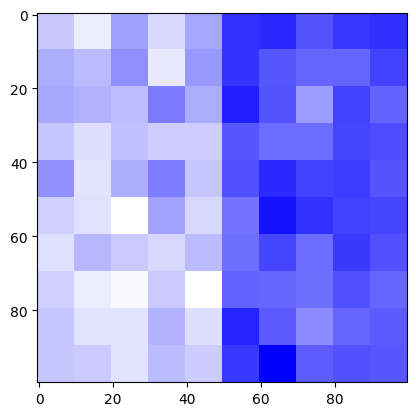

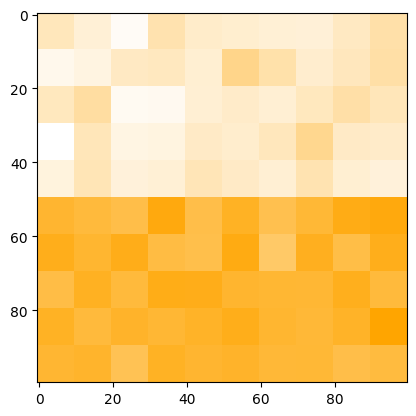

In [15]:
config = ConfigureHCCD_PCstable()
result = config.run(data)

result.var_names = var_names
result.plot_labeled_union_graph()
plt.show()
for mi in result.model_indicators():
    mi.plot_resolution()
    plt.show()